# Atoti DirectQuery with Snowflake: vectorizing data from a cloud data warehouse

When working with big data, how we store data is important. The process for how we store our data not only determines the amount of storage space our data consumes, but also affects how we implement our aggregations and how much computation power is required as a result.

This notebook demonstrates how we can make use of [vectors](https://medium.com/analytics-vidhya/what-is-a-vector-5c86fc2b57c1) to perform effective aggregation. More importantly, this notebook shows how easily we can convert repetitive data columns/rows into vectors by using [Atoti's DirectQuery](https://docs.atoti.io/latest/how_tos/use_directquery.html) to connect to a [cloud data warehouse](https://www.snowflake.com/data-cloud-glossary/data-warehousing/).

💡 **Note:** The example shown in this notebook applies regardless whether the database is hosted on cloud or on-premise (e.g. [ClickHouse](https://clickhouse.com/clickhouse) and [Microsoft SQL Server](https://www.microsoft.com/en-sg/sql-server/sql-server-downloads)).

An example of repetitive data columns/rows are values collected over time, otherwise known as time-series data. For example, we can examine [Profit and Loss (PnL)](https://en.wikipedia.org/wiki/PnL_explained) data over time. Let's see why we need vectors for such cases.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directquery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

## Why Vectors?

For this walkthrough, we will examine a [Value at Risk (VaR) calculation example using the historical method](https://www.investopedia.com/articles/04/092904.asp#toc-1-historical-method). For each trade on a given day, we have 250 days worth of historical PnL.

### Column-based historical data storage  

In the below structure, data is in a compact form as all the historical PnL is mapped to one row of key data each, corresponding to `25000` rows for the DataFrame. However, it becomes cumbersome to iterate and perform aggregations across 250 columns of data.  

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://data.atoti.io/notebooks/direct-query/data/TradePnLs_0_25000.csv"
)
df

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector1,pnl_vector2,...,pnl_vector241,pnl_vector242,pnl_vector243,pnl_vector244,pnl_vector245,pnl_vector246,pnl_vector247,pnl_vector248,pnl_vector249,pnl_vector250
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,223.0,1137.0,...,873.0,-6.0,886.0,-12.0,1310.0,-241.0,343.0,-338.0,-512.0,619.0
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,-426.0,-57.0,...,2192.0,-130.0,-73.0,1079.0,1731.0,-778.0,-75.0,2789.0,1202.0,1715.0
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,-38525.0,39667.0,...,-45607.0,-15872.0,10614.0,-1038.0,-31957.0,-27789.0,-726.0,24989.0,-12523.0,-22218.0
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,65.0,107.0,...,-19.0,332.0,9.0,67.0,-3.0,111.0,-244.0,-17.0,146.0,-193.0
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,246.0,753.0,...,285.0,-644.0,-26.0,-255.0,349.0,-684.0,986.0,-561.0,-421.0,-261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,14796.0,-15235.0,...,17516.0,6096.0,-4076.0,399.0,12274.0,10673.0,279.0,-9598.0,4810.0,8533.0
24996,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,-50.0,-83.0,...,15.0,-256.0,-7.0,-52.0,3.0,-86.0,188.0,13.0,-113.0,149.0
24997,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,NaN,NaN,NaN,EUR,246.0,753.0,...,285.0,-644.0,-26.0,-255.0,349.0,-684.0,986.0,-561.0,-421.0,-261.0
24998,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,Equity_SpaceX_Repo rate,Equity,delta,EUR,77.0,52.0,...,159.0,69.0,300.0,208.0,-170.0,-165.0,194.0,-330.0,101.0,-188.0


### Row-based historical data storage  

In the below data transformation using the Pandas [melt()](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function, we can "unpivot" a DataFrame from wide to long format to more easily work with the PnL values using the column `pnl_vector`. However, in doing so we now have duplicated data for the following columns:

* `BookId`
* `AsOfDate`
* `TradeId`
* `DataSet`
* `RiskFactor`
* `RiskClass`
* `SensitivityName`
* `ccy`

along with a resulting increase to `6250000` rows for the DataFrame.

In [2]:
pd.melt(
    df,
    id_vars=[col for col in df.columns.to_list() if not col.startswith("pnl_vector")],
    value_vars=[col for col in df.columns.to_list() if col.startswith("pnl_vector")],
    value_name="pnl_vector",
    var_name="pnl_vector_order",
)

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector_order,pnl_vector
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,pnl_vector1,223.0
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,pnl_vector1,-426.0
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,pnl_vector1,-38525.0
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,pnl_vector1,65.0
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,pnl_vector1,246.0
...,...,...,...,...,...,...,...,...,...,...
6249995,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,pnl_vector250,8533.0
6249996,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,pnl_vector250,149.0
6249997,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,NaN,NaN,NaN,EUR,pnl_vector250,-261.0
6249998,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,Equity_SpaceX_Repo rate,Equity,delta,EUR,pnl_vector250,-188.0


### Historical data stored as Vector

Therefore, by converting the PnL columns into a list of values, or what we call a Vector, we can apply aggregation operations across the vectors more easily without duplicating key data, as shown below.

In [3]:
vector_cols = [col for col in df.columns.to_list() if col.startswith("pnl_vector")]
df["pnl_vector"] = df[vector_cols].values.tolist()
df.drop(columns=vector_cols, inplace=True)
df

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,"[223.0, 1137.0, 272.0, 500.0, 158.0, 398.0, -1..."
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,"[-426.0, -57.0, -1600.0, -1020.0, 2548.0, 1593..."
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,"[-38525.0, 39667.0, -20251.0, -27725.0, 38539...."
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,"[65.0, 107.0, 94.0, 28.0, 8.0, -15.0, 270.0, 1..."
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,"[246.0, 753.0, 387.0, 259.0, 112.0, 413.0, 77...."
...,...,...,...,...,...,...,...,...,...
24995,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,"[14796.0, -15235.0, 7778.0, 10648.0, -14802.0,..."
24996,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,"[-50.0, -83.0, -73.0, -21.0, -6.0, 12.0, -208...."
24997,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,NaN,NaN,NaN,EUR,"[246.0, 753.0, 387.0, 259.0, 112.0, 413.0, 77...."
24998,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,Equity_SpaceX_Repo rate,Equity,delta,EUR,"[77.0, 52.0, -244.0, 161.0, -312.0, 55.0, -283..."


### Aggregation on Vector

In [4]:
import numpy as np


def calculate_percentile(lst):
    return np.percentile(lst, 5)


df["95% VaR"] = df["pnl_vector"].apply(calculate_percentile)
df

,BookId,AsOfDate,TradeId,DataSet,RiskFactor,RiskClass,SensitivityName,ccy,pnl_vector,95% VaR
0,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,NaN,NaN,NaN,EUR,"[223.0, 1137.0, 272.0, 500.0, 158.0, 398.0, -1...",-821.65
1,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,"[-426.0, -57.0, -1600.0, -1020.0, 2548.0, 1593...",-1354.80
2,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,"[-38525.0, 39667.0, -20251.0, -27725.0, 38539....",-50180.20
3,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,"[65.0, 107.0, 94.0, 28.0, 8.0, -15.0, 270.0, 1...",-200.55
4,1,2021-02-25,BOND_Allegheny Energy 915efcc3,Stressed,NaN,NaN,NaN,EUR,"[246.0, 753.0, 387.0, 259.0, 112.0, 413.0, 77....",-803.15
...,...,...,...,...,...,...,...,...,...,...
24995,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,"[14796.0, -15235.0, 7778.0, 10648.0, -14802.0,...",-21538.40
24996,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Historical,Interest rate_USD.OIS_Implied yield,Interest rate,delta,EUR,"[-50.0, -83.0, -73.0, -21.0, -6.0, 12.0, -208....",-162.00
24997,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,NaN,NaN,NaN,EUR,"[246.0, 753.0, 387.0, 259.0, 112.0, 413.0, 77....",-803.15
24998,1,2021-02-25,EQ_FUT_SpaceX 79fd0e13,Stressed,Equity_SpaceX_Repo rate,Equity,delta,EUR,"[77.0, 52.0, -244.0, 161.0, -312.0, 55.0, -283...",-318.10


### Database Support for Vectors

Not all databases offer native [support for vectors](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/directquery-vectors/). Some databases such as [ClickHouse](https://clickhouse.com/docs/en/sql-reference/data-types/array) offer native support for vectors as an Array type. Databases like Google BigQuery and Snowflake support list queries but not aggregation queries.

<img src="https://data.atoti.io/notebooks/direct-query/img/vector_support.png" />

Using [Atoti's aggregation function for Vectors](https://docs.atoti.io/latest/api/atoti.array.html), we can now segregate the vector computation from the database, where vectors may not be supported natively or are only partially supported. Atoti's DirectQuery fills the technical gap by emulating vectors for a database.  

## Atoti DirectQuery

Atoti supports the following list of external databases such as [Google BigQuery](https://cloud.google.com/bigquery), [ClickHouse](https://clickhouse.com/), and [Databricks](https://www.databricks.com/). Check out the documentation for the [list of databases supported](https://docs.atoti.io/latest/reference.html#directquery). In this example, we will demonstrate how we can connect to [Snowflake](https://www.snowflake.com/en/) to perform VaR computation using Vectors.  

### Getting Data
First, we'll need to download part of our data that we'll be using for this notebook.

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_data_volume.png" />

In [5]:
import zipfile
import wget
from IPython.display import clear_output, display


def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


url = "https://data.atoti.io/notebooks/direct-query/data/data.zip"
filename = wget.download(url, bar=bar_custom)

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall()

Downloading: 100% [353761897 / 353761897] bytes


### Instantiate Atoti — memory configuration

In our server instance, we have approximately `1.7TB` worth of Trade data on Snowflake. Therefore, for us, we have to prepare our Atoti server to handle the load by configuring the [memory size](https://docs.atoti.io/latest/deployment/deployment_setup.html#memory) using the `java_option` parameter during the instantiation of the session. For this walkthrough, however, we'll only be working with a portion of our Trade data, and so you may not need to configure your memory allocation (default may be good enough), but nonetheless it is helpful to know this option exists if the size of your data is expansive. 

💡 **Note:** Notice that we only need to allocate a fraction of memory to the Atoti instance in comparison to the total amount of data we have in our Snowflake instance. This is in part due to Atoti's ability to vectorize data for memory optimization.

In [6]:
import os
import atoti as tt

session = tt.Session.start(
    tt.SessionConfig(
        java_options=["-Xmx10g"],
    )
)

## Using Atoti DirectQuery with Snowflake

Before we can use Atoti DirectQuery with Snowflake, we will need to establish the following prerequisites:

* Downloading Atoti plugins
* Setting up Snowflake for Atoti DirectQuery

### Downloading Atoti plugins 
Let's first install the necessary [DirectQuery plugins](https://docs.atoti.io/latest/reference.html#directquery) and make sure that we have a valid license to [unlock all Atoti features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html).

Uncomment the following to install the plugin for the DirectQuery plugin for Snowflake.

In [7]:
# !uv pip install "atoti[directquery_snowflake]"

### Setting up Snowflake for Atoti DirectQuery

In Snowflake, we'll also need to set up the following tasks:

1. [Set up the database](#Setting-up-the-database)
1. [Create a role to grant users the permission to run queries](#Creating-a-Role-in-Snowflake)
2. [Grant privileges to the newly created role](#Granting-privileges-to-the-newly-created-role)
3. [Grant the role to a specified user](#Grant-the-role-to-a-specified-user)

💡 **Note:** Check out the documentation for more information on how to [connect Atoti DirectQuery to Snowflake](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/connect_to_external/connect_to_snowflake/).

#### Setting up the database

First things first, we'll need to have data present in a Snowflake database that Atoti DirectQuery can interact with. To do this, we'll need to create the database and schema, and then create the underlying tables with our CSVs loaded in.

Let's create a database called `ATOTI_DQ`.

![setting-up-snowflake-db](https://data.atoti.io/notebooks/direct-query/img/setting-up-snowflake-db.png)

Next, we'll create a schema called `VAR`.

![setting-up-snowflake-schema](https://data.atoti.io/notebooks/direct-query/img/setting-up-snowflake-schema.png)

Finally, we'll create the following tables and load data from our CSVs, respectively, by selecting *Create* > *Table* > *From File*.

* `BOOKS`: Load data using `books_books.csv`
* `TRADE_PNLS`: Load data using all `TradePnLs_*.csv` files
* `VECTOR_POSITIONS`: Load data using `vector_positions_vector_positions.csv`

![setting-up-snowflake-tables](https://data.atoti.io/notebooks/direct-query/img/setting-up-snowflake-tables.png)

Our database should now be ready-to-go, and should look like the following:

![complete-snowflake-db](https://data.atoti.io/notebooks/direct-query/img/complete-snowflake-db.png)

#### Creating a Role in Snowflake

In addition, we'll need to create a role in Snowflake that we can bind to a user. We can either use the Snowflake GUI to create the `QUERIER` role interactively, like so... 

![create-snowflake-role-gui](https://data.atoti.io/notebooks/direct-query/img/create-snowflake-role-gui.png)

Or, we can run the following SQL within a SQL Worksheet to create the `QUERIER` role as an alternative:  

```sql
CREATE ROLE IF NOT EXISTS QUERIER COMMENT="Role to run queries"
```

![create-snowflake-role-sql](https://data.atoti.io/notebooks/direct-query/img/create-snowflake-role-sql.png)

#### Granting privileges to the newly created role

Next, we'll need to grant our newly created role the [minimum privileges](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/connect_to_external/connect_to_snowflake/#grant-required-privileges-to-this-role) required by Atoti DirectQuery to successfully query the database.

We can run the following SQL to grant the necessary privileges to the `QUERIER` role that we just created:
                                                         
```sql
GRANT USAGE ON WAREHOUSE COMPUTE_WH TO ROLE QUERIER;
GRANT USAGE ON DATABASE ATOTI_DQ TO ROLE QUERIER;
GRANT USAGE ON SCHEMA VAR TO ROLE QUERIER;
GRANT SELECT ON ALL TABLES IN SCHEMA ATOTI_DQ.VAR to ROLE QUERIER;
```

💡 **Note:** The above SQL will work for the names that we've given for the database, schema, and tables for this walkthrough. However, be mindful of the name of the warehouse that you are executing your SQL against, as this may differ. For more information on granting privileges, consult the [granting privileges](https://docs.snowflake.com/en/sql-reference/sql/grant-privilege#examples) documentation in Snowflake.  

![granting-privileges-to-role](https://data.atoti.io/notebooks/direct-query/img/granting-privileges-to-role.png)

Once privileges have been granted to the `QUERIER` role for the specified database objects, we should confirm this has been properly set by visiting each of the objects' details page and checking the associated *Privileges*.

![verify-privileges](https://data.atoti.io/notebooks/direct-query/img/verify-privileges.png)

#### Grant the role to a specified user

Finally, let's create a new user called `APP_USER` and grant the account the `QUERIER` role that we defined with the aforementioned privileges.

Go to *Admin* > *Users & Roles* and click the *+ User* button to create the new user, `APP_USER`. For this walkthrough, we've set the password for `APP_USER` as `Password123!`, however, if you choose to set a different password, take note as we will need this for Atoti DirectQuery to successfully authenticate as `APP_USER` and query the database.

![create-user](https://data.atoti.io/notebooks/direct-query/img/create-user.png)

Grant the above role to user:  

![granting-role-to-user](https://data.atoti.io/notebooks/direct-query/img/granting-role-to-user.png)

### Connecting Atoti DirectQuery to Snowflake

#### Import Plugins for DirectQuery 

We will be using two components from the DirectQueryPlugin:

* [SnowflakeConnectionInfo](https://docs.atoti.io/latest/api/atoti_directquery_snowflake.SnowflakeConnectionInfo.html): Configure the connection information to Snowflake.
* [SnowflakeTableOptions](https://docs.atoti.io/latest/api/atoti_directquery_snowflake.SnowflakeTableOptions.html): Configure the table options about the external table to create in Atoti.

💡 **Note:** When connecting Atoti DirectQuery to other databases, use the corresponding components. For example, we would use [ClickhouseConnectionInfo](https://docs.atoti.io/latest/api/atoti_directquery_clickhouse.ClickhouseConnectionInfo.html) and [ClickhouseTableOptions](https://docs.atoti.io/latest/api/atoti_directquery_clickhouse.ClickhouseTableOptions.html) if we are connecting Atoti DirectQuery to [ClickHouse](https://clickhouse.com/).

In [8]:
import os
from atoti_directquery_snowflake import ConnectionConfig, TableConfig

#### JDBC Connection URL to Snowflake

We will connect to Snowflake using a [JDBC URL](https://docs.snowflake.com/en/developer-guide/jdbc/jdbc-configure#jdbc-driver-connection-string).  

To uniquely identify an account in Snowflake, we must prepend our organization name to the account name:

`<orgname>-<account_name>`  

You can find this information from the Snowflake account pane located in the bottom-left corner of the Snowflake web UI:

![setting-up-jdbc-url](https://data.atoti.io/notebooks/direct-query/img/setting-up-jdbc-url.png)

<!-- 
<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_account.png" />  
 -->

Clicking on the *Copy account identifier* button will return your account information in the form of `<orgname>.<account_name>`. Replace the `.` with a hyphen instead, as we need `<orgname>-<account_name>` for the JDBC URL. For example, we needed to change `LZRGGUE.EP41558` to `LZRGGUE-EP41558` instead for our use case.

In addition, we should store the following account information as environment variables as a best practice rather than expose sensitive information within code. For `SNOWFLAKE_USERNAME` and `SNOWFLAKE_PASSWORD`, use the user that we granted the `QUERIER` role to with the defined privileges. For this walkthrough, the user would be `APP_USER` and the password would be `Password123!`, but if you have chosen a different password in the previous steps, use your specific password.

* `SNOWFLAKE_ACCOUNT_IDENTIFIER`
* `SNOWFLAKE_USERNAME`
* `SNOWFLAKE_PASSWORD`
* `SNOWFLAKE_ROLE`
* `SNOWFLAKE_WAREHOUSE`
* `SNOWFLAKE_DATABASE`
* `SNOWFLAKE_SCHEMA`

Windows users may be more familiar with setting the above environment variables using the desktop GUI.

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_env_variable.png" />

While macOS and Linux users can execute the following code in the terminal.

```bash
export SNOWFLAKE_ACCOUNT_IDENTIFIER=<orgname>-<account_name>
export SNOWFLAKE_USERNAME=<user>
export SNOWFLAKE_PASSWORD=<password>
export SNOWFLAKE_ROLE=<role>
export SNOWFLAKE_WAREHOUSE=<warehouse>
export SNOWFLAKE_DATABASE=<database>
export SNOWFLAKE_SCHEMA=<schema>
```

For the sake of this walkthrough, the above would look like the following:

```bash
export SNOWFLAKE_ACCOUNT_IDENTIFIER=LZRGGUE-EP41558
export SNOWFLAKE_USERNAME=APP_USER
export SNOWFLAKE_PASSWORD=Password123!
export SNOWFLAKE_ROLE=QUERIER
export SNOWFLAKE_WAREHOUSE=COMPUTE_WH
export SNOWFLAKE_DATABASE=ATOTI_DQ
export SNOWFLAKE_SCHEMA=VAR
```

In [9]:
# os.environ["SNOWFLAKE_ACCOUNT_IDENTIFIER"] = SDLWLHU-XO19970
connection_info = ConnectionConfig(
    url=f"jdbc:snowflake://{os.environ['SNOWFLAKE_ACCOUNT_IDENTIFIER']}.snowflakecomputing.com/?user={os.environ['SNOWFLAKE_USERNAME']}&role={os.environ['SNOWFLAKE_ROLE']}&warehouse={os.environ['SNOWFLAKE_WAREHOUSE']}&database={os.environ['SNOWFLAKE_DATABASE']}&schema={os.environ['SNOWFLAKE_SCHEMA']}",
    password=os.environ["SNOWFLAKE_PASSWORD"],
)

db = session.connect_to_external_database(connection_info)

In [10]:
db.tables

Once we establish the connection, we can [add tables from the external database](https://docs.atoti.io/latest/api/atoti.Session.add_external_table.html#atoti.Session.add_external_table) to our Atoti session. In this case, we can add the external `TRADE_PNLS` table to our Atoti session.  

In [11]:
db.tables["TRADE_PNLS"]

The table contains 250 PnL values for each `TRADEID` per `ASOFDATE`, i.e. 1 year of historical PnL.  

<img src="https://data.atoti.io/notebooks/direct-query/img/snowflake_data.gif"  style="width:75%; margin:0 auto;"/> 
  
Using Atoti DirectQuery, we can now convert these `PNL_VECTOR` columns into arrays using [MultiColumnArrayConversion](https://docs.atoti.io/latest/api/atoti.MultiColumnArrayConversion.html#atoti.MultiColumnArrayConversion), optimizing the memory usage. In the event the PnL values are stored across rows rather than columns, we can convert them into arrays using [MultiRowArrayConversion](https://docs.atoti.io/latest/api/atoti.MultiRowArrayConversion.html#atoti.MultiRowArrayConversion) instead.  

In [12]:
trades_atoti = session.add_external_table(
    db.tables["TRADE_PNLS"],
    table_name="Trade PnL",
    config=TableConfig(
        keys=["ASOFDATE", "TRADEID", "BOOKID", "DATASET"],
        array_conversion=tt.MultiColumnArrayConversion(column_prefixes=["PNL_VECTOR"]),
    ),
)

In [13]:
session.link

http://localhost:52499

Instead of managing 250 PnL columns that are named differently, the columns prefixed with `PNL_VECTOR` is now converted to a single column called `PNL_VECTOR`. The object is of now of the type `DOUBLE[]`.

In [14]:
trades_atoti.head()

RISKFACTOR  \
TRADEID                       ASOFDATE   DATASET    BOOKID                                        
EQ_FUT_BESP_BASKET_1 08b26298 2021-02-25 Historical 2           Equity_BESP_BASKET_1_Spot price   
                                                    2           Foreign exchange_USD_Spot price   
                                                    2       Interest rate_USD.OIS_Implied yield   
                                         Stressed   2                                       N/A   
                                                    2            Equity_BESP_BASKET_1_Repo rate   

                                                                   RISKCLASS  \
TRADEID                       ASOFDATE   DATASET    BOOKID                     
EQ_FUT_BESP_BASKET_1 08b26298 2021-02-25 Historical 2                 Equity   
                                                    2       Foreign exchange   
                                                    2          Interest rate   
                                         Stressed   2                    N/A   
                                                    2                 Equity   

                                                           SENSITIVITYNAME  \
TRADEID                       ASOFDATE   DATASET    BOOKID                   
EQ_FUT_BESP_BASKET_1 08b26298 2021-02-25 Historical 2                delta   
                                                    2                delta   
                                                    2                delta   
                                         Stressed   2                  N/A   
                                                    2                delta   

                                                            CCY  \
TRADEID                       ASOFDATE   DATASET    BOOKID        
EQ_FUT_BESP_BASKET_1 08b26298 2021-02-25 Historical 2       EUR   
                                                    2       EUR   
                                                    2       EUR   
                                         Stressed   2       EUR   
                                                    2       EUR   

                                                                                                   PNL_VECTOR  
TRADEID                       ASOFDATE   DATASET    BOOKID                                                     
EQ_FUT_BESP_BASKET_1 08b26298 2021-02-25 Historical 2       [46661.0, 7335.0, 132860.0, 139213.0, -9436.0,...  
                                                    2       [-637.0, 366.0, -853.0, -2293.0, 846.0, 485.0,...  
                                                    2       [-44.0, 10.0, -13.0, -28.0, 15.0, 8.0, 20.0, -...  
                                         Stressed   2       [129.0, 486.0, 474.0, -815.0, 324.0, 43.0, -77...  
                                                    2       [-708.0, -56.0, -1176.0, -858.0, -1046.0, -34....

In [15]:
trades_atoti.row_count

765754

## Creating and enriching the Atoti cube

We can also create more Atoti tables and join them to the base table.

In [16]:
books_atoti = session.add_external_table(
    db.tables["BOOKS"], config=TableConfig(keys=["BOOKID"])
)

trades_atoti.join(books_atoti)

And proceed to create a cube as usual for Atoti applications that use other data sources. We can easily replace the data sources and retain the same code from this point onwards.

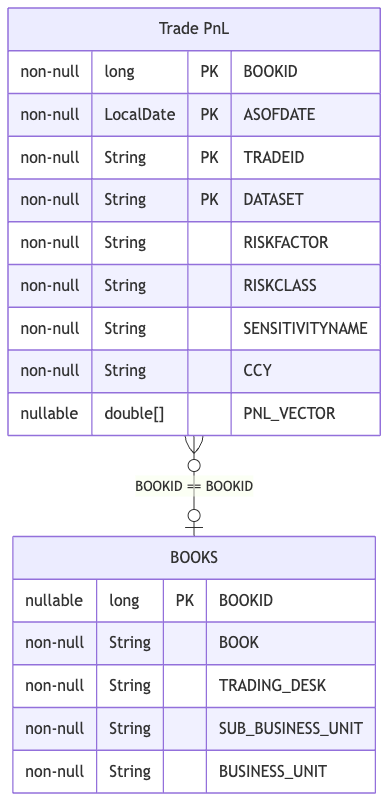

In [17]:
cube = session.create_cube(trades_atoti)
session.tables.schema

In [18]:
cube

### Hierarchy manipulation

In [19]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [20]:
l["ASOFDATE"].order

NaturalOrder(ascending=True)

In [21]:
h["ASOFDATE"].slicing = True
l["ASOFDATE"].order = tt.NaturalOrder(ascending=False)

In [22]:
h["TRADING BOOK HIERARCHY"] = [
    books_atoti["BUSINESS_UNIT"],
    books_atoti["SUB_BUSINESS_UNIT"],
    books_atoti["TRADING_DESK"],
    books_atoti["BOOK"],
]

del h["BUSINESS_UNIT"]
del h["SUB_BUSINESS_UNIT"]
del h["TRADING_DESK"]
del h["BOOK"]

And finally, Atoti is able to query data from Snowflake without storing the data in-memory.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
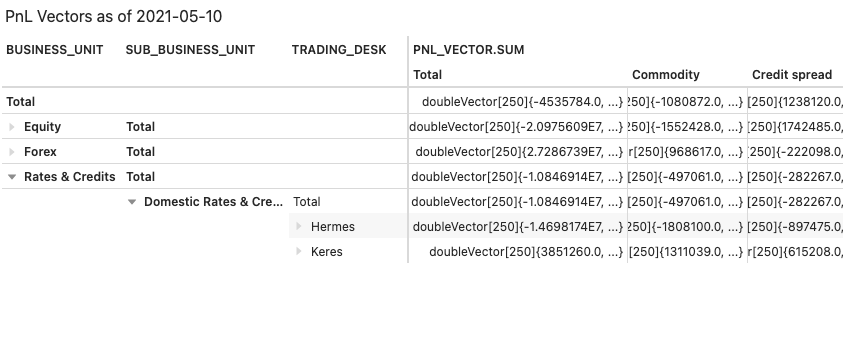

In [23]:
session.widget

## Non-linear aggregation - Computing VaR 95 using Vector aggregation

Since we have the `PNL_VECTOR.SUM`, which is the sum of the PnL value for each historical date, we can easily compute [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) at 95% confidence level using the vector as shown below:

In [24]:
m["VaR95"] = tt.array.quantile(m["PNL_VECTOR.SUM"], 1 - 0.95)

Depending on the query, VaR 95 is computed on the fly for each level in the query.

In [25]:
%%time
cube.query(m["VaR95"], levels=[l["BOOKID"]], filter=(l["ASOFDATE"] == "2021-03-01"))

CPU times: user 23.8 ms, sys: 4.16 ms, total: 28 ms
Wall time: 2 s


,VaR95
BOOKID,
1,"-12,901,400.75"
2,"-17,532,243.70"
3,"-25,374,649.55"
4,"-16,082,705.80"
5,"-16,748,647.90"


## Speeding things up with Hybrid model

Queries depends on the performance of Snowflake. However, we can employ a hybrid approach where we cache the data which we are actively using in-memory. In this case, we will cache the data for all the levels other than `TRADEID` as of the latest `ASOFDATE` which is `2021-03-01`.

In [26]:
from datetime import date

current_date = date(2021, 3, 1)

We exclude the `TRADEID` level in our aggregate provider as it is too granular and will increase the cardinality of our query. We also remove the shallower levels of the `TRADING BOOK HIERARCHY`, leaving only the deepest `BOOK` level. This is because when specifying the `levels` parameter for the Aggregate Provider, only the deepest level should be passed. If a passed level is part of a multilevel hierarchy, all shallower levels will be pre-aggregated too.

In [27]:
[
    name
    for name, lvl in l.items()
    if not any(
        substr in name
        for substr in ("TRADEID", "BUSINESS_UNIT", "SUB_BUSINESS_UNIT", "TRADING_DESK")
    )
]

[('Trade PnL', 'DATASET', 'DATASET'),
 ('Trade PnL', 'SENSITIVITYNAME', 'SENSITIVITYNAME'),
 ('Trade PnL', 'BOOKID', 'BOOKID'),
 ('Trade PnL', 'ASOFDATE', 'ASOFDATE'),
 ('Trade PnL', 'RISKFACTOR', 'RISKFACTOR'),
 ('Trade PnL', 'RISKCLASS', 'RISKCLASS'),
 ('Trade PnL', 'CCY', 'CCY'),
 ('BOOKS', 'TRADING BOOK HIERARCHY', 'BOOK')]

The following snippet will take a while to finish running as it queries the data from Snowflake and caches it in the memory.

In [28]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="bitmap",
            levels=[
                lvl
                for name, lvl in l.items()
                if not any(
                    substr in name
                    for substr in (
                        "TRADEID",
                        "BUSINESS_UNIT",
                        "SUB_BUSINESS_UNIT",
                        "TRADING_DESK",
                    )
                )
            ],
            measures=[m["PNL_VECTOR.SUM"]],
            filter=l["ASOFDATE"] == current_date,
            partitioning="hash16(BOOKID)",
        )
    }
)

Now, the same query returns the results significantly quicker as we query the data in-memory instead of hitting Snowflake.

In [29]:
%%time
cube.query(m["VaR95"], levels=[l["BOOKID"]], filter=(l["ASOFDATE"] == "2021-03-01"))

CPU times: user 9.02 ms, sys: 2.86 ms, total: 11.9 ms
Wall time: 102 ms


,VaR95
BOOKID,
1,"-12,901,400.75"
2,"-17,532,243.70"
3,"-25,374,649.55"
4,"-16,082,705.80"
5,"-16,748,647.90"


## Multidimensional Analytics Capability

In addition, we still enjoy the same multidimensional analytic capability that Atoti offers! Changing our perspective from `BOOKID` to `BUSINESS_UNIT`, we still get the results at an exceptional speed!

💡 **Note:** As we have performed a slicing on the `ASOFDATE` which is in descending order, this ensure that we query only data from the latest date when no date is defined. This ensure that we do not retrieve too much data unnecessarily. 

In [30]:
%%time
cube.query(m["VaR95"], levels=[l["BUSINESS_UNIT"]])

CPU times: user 6.76 ms, sys: 2.22 ms, total: 8.97 ms
Wall time: 41.5 ms


,VaR95
BUSINESS_UNIT,
Equity,"-17,532,243.70"
Forex,"-25,374,649.55"
Rates & Credits,"-27,125,953.00"


## Conclusion  

Let's review some of the key points:

* By storing the historical PnL as Vectors, we can reduce our memory footprint and simplify aggregations in Atoti.  

* While we have 1.7TB of data in our Snowflake database, we only have to configure 10GB of memory for our Atoti instance. The 10GB is sufficient for us to hold a single day of data in-memory.

* We can always query the external database with some trade-offs in performance, but by leveraging the benefit of in-memory data through the use of an aggregate provider, we are able to have greater performance for frequently queried data, and also save costs by having a reduced number of queries hit the Snowflake database.  

* Overall, using Atoti DirectQuery saves on total costs by decoupling data storage and query optimization — users can keep their data in cloud data warehouses and optimize queries in Atoti for frequent or "hot data" rather than keeping all data in the in-memory cube.

<img src="https://data.atoti.io/notebooks/direct-query/img/cost_model.png" style="width:75%;"/>   

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directquery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>